READ AND PREPARE DATA

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import seaborn as sn
drRatings = pd.read_excel('./OBGYN_new_train_80000.xlsx')
#shuffle the data so that they are in random sequence
drRatings = drRatings.sample(frac=1)
drRatings['knowledge'] = (drRatings['knowledge']>4).astype(int)

temp = pd.get_dummies(drRatings['state']).astype(int)
drRatings = pd.concat([drRatings,temp],axis=1)
del temp
drRatings['postedTime']=pd.to_datetime(drRatings['postedTime'])
drRatings['year']=drRatings['postedTime'].dt.year
drRatings['hour']=drRatings['postedTime'].dt.hour

In [ ]:
import re
from sklearn import feature_extraction
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess(text):
  text = text.lower() #lowercase
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ["dr", "doctor"]] #remove task specific stopwords
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_extraction
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
stop_words = ["dr", "doctor"] + list(stop_words)

def calTFIDF(texts,max_features=None):
  vectorizer = TfidfVectorizer(max_features=max_features,lowercase=True,stop_words=stop_words,ngram_range=(1,1))
  TFIDF = vectorizer.fit_transform(texts)
  TFIDF=pd.DataFrame(TFIDF.toarray(),columns=vectorizer.get_feature_names_out())
  return(TFIDF)

In [ ]:
drRatings['text'] = drRatings['review'].apply(lambda x:preprocess(x))

In [ ]:
TFIDF=calTFIDF(drRatings['text'],max_features=250)
TFIDF

,able,absolutely,actually,ago,amazing,answer,answered,answers,appointment,appointments,...,woman,women,wonderful,work,worst,worth,wouldnt,wrong,year,years
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.369836,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.241362
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.334505,0.0,0.0,0.0,0.0,0.0,0.0,0.299025
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.274992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
79996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
79997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.390847
79998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


SPLIT DATA

TRAIN WITH 70K

In [ ]:
xcols = ['AK', 'AL', 'AR', 'AZ', 'CA','CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY', 'year', 'hour','numReviews']

ycol = 'knowledge'
x = drRatings[xcols].values
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF.values],axis=1)
y = drRatings[ycol]


x_test=x[:10000]
x_train=x[10000:]
y_test=y[:10000]
y_train=y[10000:]
drRatings=drRatings.reset_index(drop=True)
drRatings_test=drRatings.loc[:9999]
drRatings_test=drRatings_test.reset_index(drop=True)
drRatings_train=drRatings.loc[10000:]
drRatings_train=drRatings_train.reset_index(drop=True)

logit_model1 = sm.Logit(y_train, x_train)
logit_result = logit_model1.fit()

Optimization terminated successfully.
         Current function value: 0.288619
         Iterations 8


IN SAMPLE PREDICTION EVALUATION

prediction accuracy is 0.8862428571428571


Text(50.722222222222214, 0.5, 'kowledge')

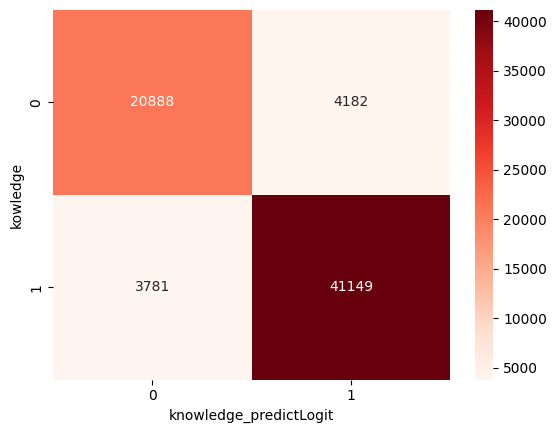

In [ ]:
drRatings_train['knowledge_predictLogit'] = (logit_result.predict(x_train) >= 0.5).astype(int).tolist()
acc=metrics.accuracy_score(y_true=drRatings_train['knowledge'],y_pred=drRatings_train['knowledge_predictLogit'])
print('prediction accuracy is',acc)
confusion=metrics.confusion_matrix(y_true=drRatings_train['knowledge'],y_pred=drRatings_train['knowledge_predictLogit'])
# print(confusion)
sn.heatmap(confusion, annot=True, cmap='Reds', fmt='d')
plt.xlabel("knowledge_predictLogit")
plt.ylabel("kowledge")

OUT OF SAMPLE PREDICTION WITH 10K

prediction accuracy is 0.8873


Text(50.722222222222214, 0.5, 'knowledge')

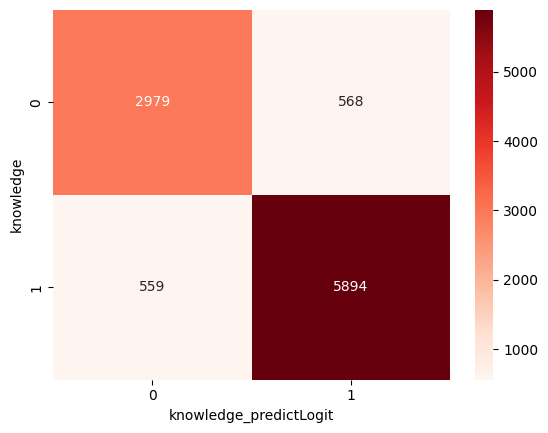

In [ ]:
drRatings_test['knowledge_predictLogit'] = (logit_result.predict(x_test) >= 0.5).astype(int)
acc=metrics.accuracy_score(y_true=drRatings_test['knowledge'],y_pred=drRatings_test['knowledge_predictLogit'])
print('prediction accuracy is',acc)
confusion=metrics.confusion_matrix(y_true=drRatings_test['knowledge'],y_pred=drRatings_test['knowledge_predictLogit'])
# print(confusion)
sn.heatmap(confusion, annot=True, cmap='Reds', fmt='d')
plt.xlabel("knowledge_predictLogit")
plt.ylabel("knowledge")

OUT OF SAMPLE PREDICTION

READ AND PREPARE DATA

In [ ]:
testingdata = pd.read_excel('./OBGYN_new_test_withoutAnswer_20000_2024.xlsx')

In [ ]:
temp = pd.get_dummies(testingdata['state']).astype(int)
testingdata = pd.concat([testingdata,temp],axis=1)
del temp
states=drRatings['state'].unique().tolist()
for state in states:
  if state not in testingdata.columns.tolist():
    testingdata[state]=[0]*testingdata.shape[0]
testingdata['postedTime']=pd.to_datetime(testingdata['postedTime'])
testingdata['year']=testingdata['postedTime'].dt.year
testingdata['hour']=testingdata['postedTime'].dt.hour


In [ ]:
testingdata['text'] = testingdata['review'].apply(lambda x:preprocess(x))

In [ ]:
alltext=drRatings['text'].tolist()+testingdata['text'].tolist()

COMBINE TRAINING AND TESTING TEXTS TO GENERATE A CONSISTENT TFID MATRIX

In [ ]:
TFIDF=calTFIDF(alltext,max_features=250)
TFIDF.columns = ['tfidf_'+x for x in TFIDF.columns]
TFIDF_train = TFIDF[:80000]
TFIDF_test = TFIDF[80000:]
TFIDF_test=TFIDF_test.reset_index(drop=True)
TFIDF

,tfidf_able,tfidf_absolutely,tfidf_actually,tfidf_ago,tfidf_amazing,tfidf_answer,tfidf_answered,tfidf_answers,tfidf_appointment,tfidf_appointments,...,tfidf_woman,tfidf_women,tfidf_wonderful,tfidf_work,tfidf_worst,tfidf_worth,tfidf_wouldnt,tfidf_wrong,tfidf_year,tfidf_years
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.369195,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.241319
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.334942,0.0,0.0,0.0,0.0,0.0,0.0,0.298797
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.274864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
99996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
99997,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.119159
99998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


TRAIN MODEL USING 80K

In [ ]:
xcols = ['AK', 'AL', 'AR', 'AZ', 'CA','CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD',
       'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY', 'year', 'hour','numReviews']

ycol = 'knowledge'
x = drRatings[xcols].values
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF_train.values],axis=1)
y = drRatings[ycol]


logit_model1 = sm.Logit(y, x)
logit_result = logit_model1.fit()


Optimization terminated successfully.
         Current function value: 0.288760
         Iterations 8


GENERATE PREDICTIONS FOR TESTING DATA

In [ ]:
x = testingdata[xcols].values
x = sm.add_constant(x)
x = np.concatenate([x,TFIDF_test.values],axis=1)


pred = (logit_result.predict(x) >= 0.5).astype(int)
pred_prob = logit_result.predict(x)

In [ ]:
submitcsv=pd.DataFrame()
submitcsv['reviewID']=testingdata['reviewID'].tolist()
submitcsv['prediction']=pred
submitcsv.to_csv('32622300_dieguito.csv',index=False)
print(submitcsv)

       reviewID  prediction
0         80001           1
1         80002           1
2         80003           1
3         80004           1
4         80005           1
...         ...         ...
19995     99996           0
19996     99997           1
19997     99998           0
19998     99999           1
19999    100000           1

[20000 rows x 2 columns]
